In [97]:
% matplotlib notebook
import sigpy.plot as pl
import numpy as np
import sigpy as sp
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import scipy.io
from torch.autograd import Variable
import UFNet
import os
import resnet
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#Knee data folders: 
folder_knee = "/mikRAID/frank/data/cube_knees/train_ksp_slices/"
files_knee = os.listdir(folder_knee)
# len(files_knee)/
files_knee_valid = list([])
for i in files_knee:
        if os.path.splitext(i)[1] == '.npy':
            files_knee_valid.append(i)

In [5]:
def dir2dic(dir_list):
    n = len(dir_list)
    output = list([])
    for i in range(n):
        dir_n = dir_list[i]
        dk = list([dir_n])
        dk.extend(dir_n[:-4].split("_"))
        output.append(dk)
    return output
# files_knee_valid[0][:-4].split("_")

In [7]:
# Construct dir dictionary and permuta the number
dir_dic = dir2dic(files_knee_valid)
n_elements = len(dir_dic)
dic_num = np.random.permutation(n_elements)
def index2torch(index_dic,dir_dic,folder):
    n_index = index_dic.shape[0]
    for jj in range(n_index):
        if jj == 0:
            outp = np.load(folder+dir_dic[index_dic[0]][0])[None,:,:,:]
        else:
            outp = np.concatenate((outp,np.load(folder+dir_dic[index_dic[jj]][0])[None,:,:,:]))
    return torch.tensor(np.concatenate((outp.real,outp.imag),1))

In [10]:
dic = np.array(dir_dic)

In [20]:
dic_case = dic[:,1].astype(int)

<IPython.core.display.Javascript object>


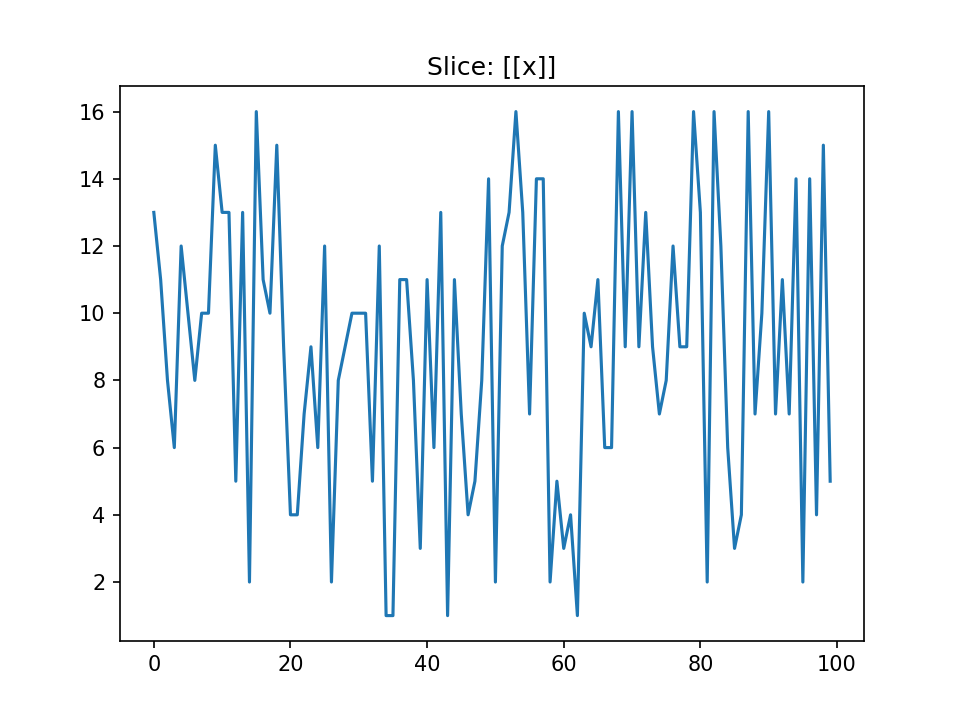

In [33]:
pl.LinePlot(dic_case[:100])

In [36]:
def searchdic(case,slic,dic):
    n = dic.shape[0]
    for i in range(n):
        if dic[i,1].astype(int) == case and dic[i,2].astype(int) == slic:
            return i
            

In [174]:
def find_neighbors(case,slic,num_neighbor = 10,farest = False):
    k = searchdic(case,slic,dic)
    inp =  dic_compressed[k,:][:,None]
    corr = list(dic_compressed.dot(inp)[:,0])
    p = corr.copy()
    p.sort()
    if farest:
        p.reverse()
    n_neighbor = num_neighbor
    nei_index = list([])
    nei_corr = list([])
    for jj in range(n_neighbor+1):
        nei_index.append(corr.index(p[-1*(jj+1)]))
        nei_corr.append(corr[corr.index(p[-1*(jj+1)])])
    name_neighbor = list([])
    for ii in range(n_neighbor+1):
        if ii == 0:
            ind = nei_index[ii]
            name = folder_knee + dic[ind,0]
            data_kspace = np.load(name)
            data_im = sp.rss(sp.ifft(data_kspace,axes=[-2,-1]))
        elif ii == 1:
            ind = nei_index[ii]
            name = folder_knee + dic[ind,0]
            data_kspace_n = np.load(name)
            data_im_n = sp.rss(sp.ifft(data_kspace_n,axes=[-2,-1]))[None,:,:]
            name_neighbor.append(dic[ind,0])
    #         break
        else:
            ind = nei_index[ii]
            name = folder_knee + dic[ind,0]
            data_kspace_n = np.load(name)
            data_im_n = np.concatenate((data_im_n,sp.rss(sp.ifft(data_kspace_n,axes=[-2,-1]))[None,:,:]))
            name_neighbor.append(dic[ind,0])        
    return data_im,data_im_n,name_neighbor,nei_corr

In [188]:
case = 7
slic = 80
n_nei = 10
data_im_o,data_im_nei,name_nei,nei_corr = find_neighbors(case,slic,n_nei,farest=True)

In [189]:
nei_corr

[-0.9999668,
 -0.9993662,
 -0.9982867,
 -0.99754363,
 -0.99736756,
 -0.99669164,
 -0.9950334,
 -0.99434024,
 -0.9942395,
 -0.9941079,
 -0.9939392]

In [190]:
name_nei

['4_40.npy',
 '4_28.npy',
 '4_38.npy',
 '4_34.npy',
 '15_34.npy',
 '4_33.npy',
 '15_30.npy',
 '15_41.npy',
 '15_39.npy',
 '4_31.npy']

<IPython.core.display.Javascript object>


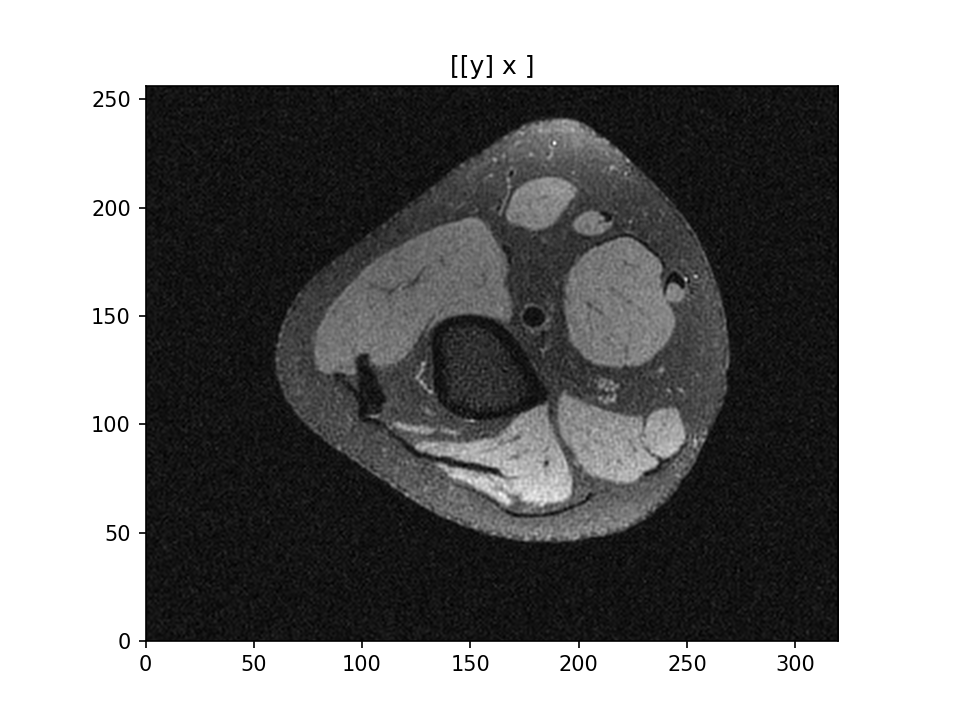

In [191]:
pl.ImagePlot(data_im_o)

<IPython.core.display.Javascript object>


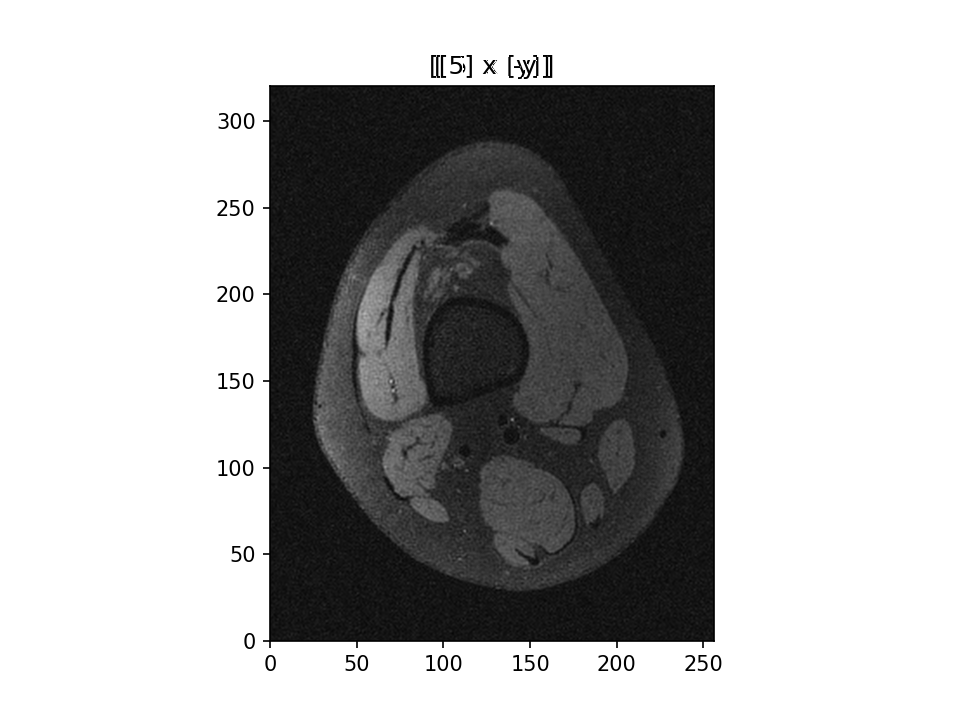

In [192]:
pl.ImagePlot(data_im_nei)

In [94]:
p = np.load(folder_knee+dic[4034,0])

In [95]:
sp.r

(8, 256, 320)

In [90]:
nei_index

[4034, 4841, 2772, 2793, 3676, 4728, 3680, 1645, 3252, 4338, 28]

In [89]:
nei_corr

[1.0,
 0.9997537,
 0.99973035,
 0.9997226,
 0.9997177,
 0.9994739,
 0.9992305,
 0.998988,
 0.99856114,
 0.99823785,
 0.99819946]

In [78]:
corr

[-0.7085607,
 0.24701418,
 0.9472978,
 0.16297382,
 0.8541946,
 0.5037371,
 0.96036285,
 0.8856559,
 0.9294614,
 0.45461616,
 -0.77378714,
 -0.66931146,
 -0.8502774,
 -0.67670745,
 0.06177461,
 -0.73096055,
 0.3062643,
 0.61838293,
 0.709622,
 -0.7765367,
 0.38370085,
 0.3298524,
 0.026677877,
 -0.55140436,
 0.1495361,
 0.19723973,
 -0.16127354,
 0.929322,
 0.99819946,
 -0.10184097,
 0.9730195,
 0.9279883,
 -0.6729763,
 -0.054184765,
 -0.42551434,
 -0.3398047,
 -0.04723592,
 0.5084353,
 0.92687637,
 0.20301905,
 0.21318173,
 -0.18355596,
 -0.86186254,
 -0.21982002,
 -0.040653795,
 -0.74762523,
 0.69895524,
 -0.6316161,
 0.7308435,
 -0.1127028,
 0.26420066,
 0.93034226,
 -0.673983,
 -0.2899912,
 -0.68948,
 -0.35220036,
 0.27446288,
 -0.7223959,
 0.29377237,
 0.50725204,
 0.14595483,
 0.40314257,
 -0.13391532,
 0.19213775,
 -0.14257732,
 0.39716825,
 0.12915039,
 -0.43451285,
 -0.29742172,
 -0.19062006,
 -0.7373527,
 -0.099347174,
 -0.5665915,
 0.98349476,
 0.9659693,
 -0.051196143,
 -0.

In [54]:
corr = dic_compressed.dot(inp)

In [62]:
p =list(corr[:,0])

In [81]:
corr.index(p[-2])

4841

In [67]:
p.sort()

In [59]:
corr

array([[-0.7085607 ],
       [ 0.24701418],
       [ 0.9472978 ],
       ...,
       [-0.09544189],
       [ 0.07676822],
       [-0.4487343 ]], dtype=float32)

<IPython.core.display.Javascript object>


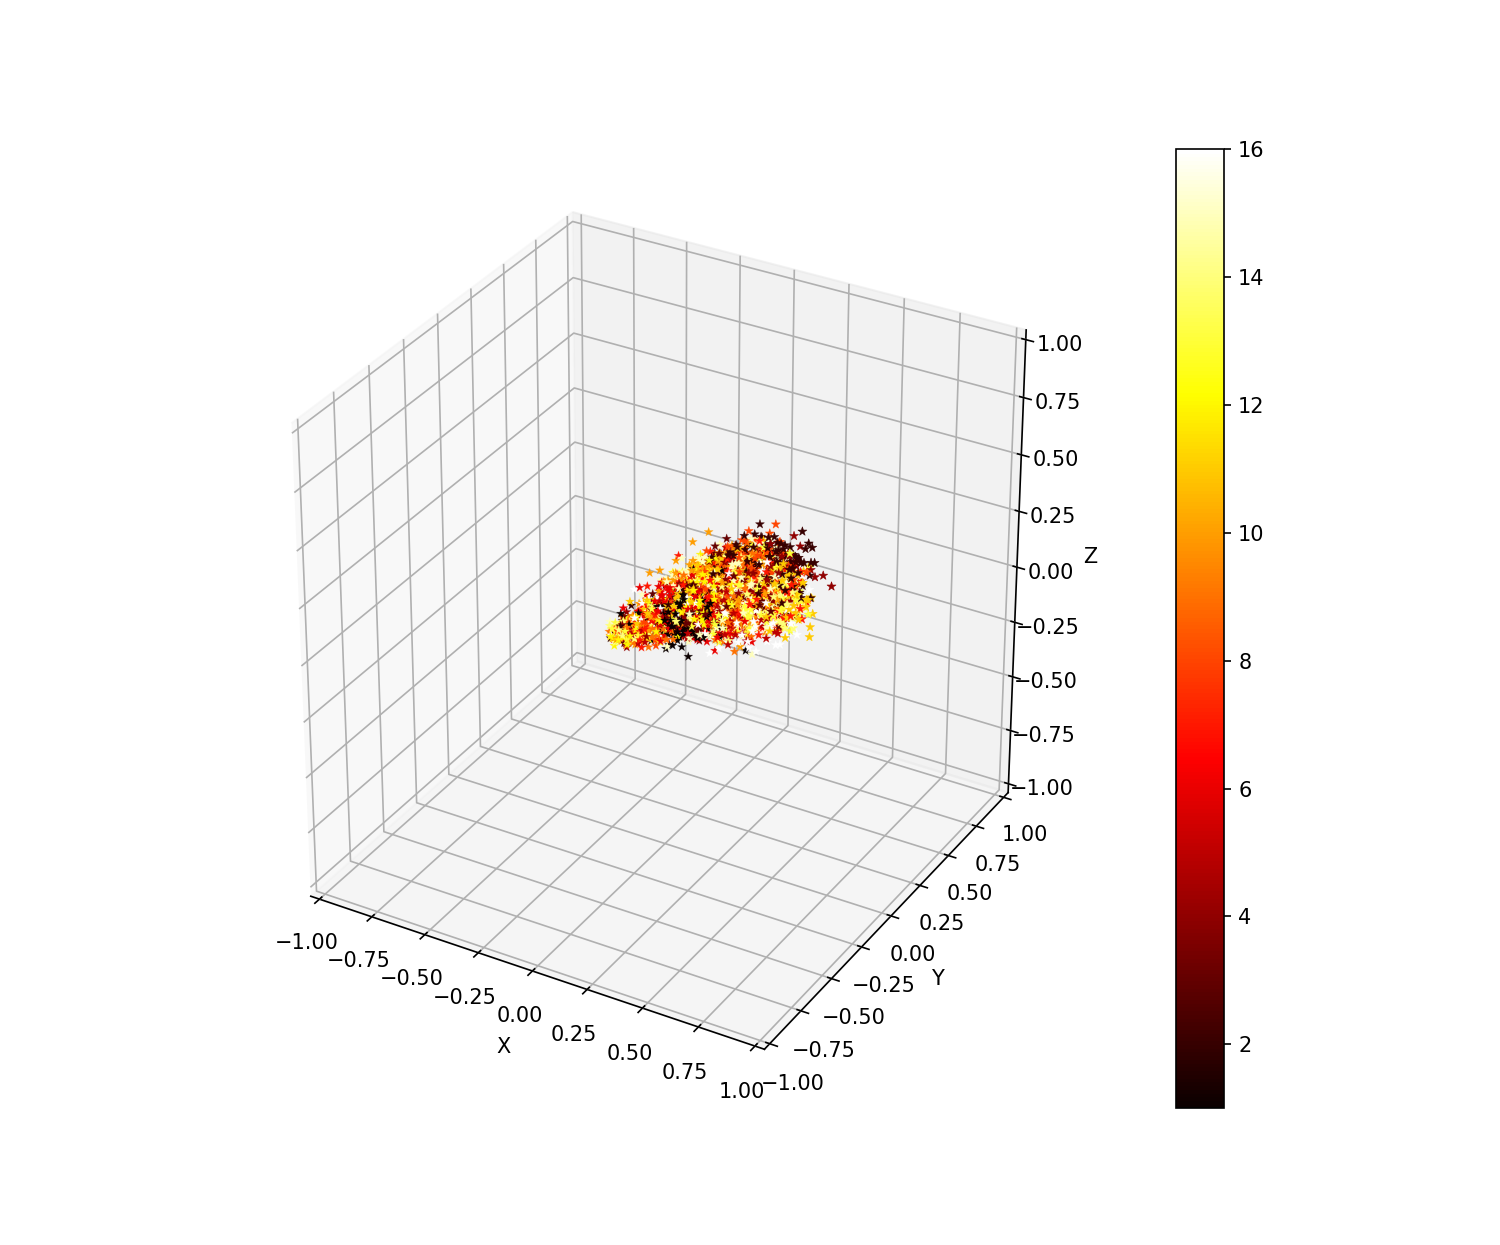

In [145]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
dic_compressed = np.load("kspace_unsupervised_resnet_init.npy")
# dic_compressed = B_tensor_cuda.detach().cpu().numpy()
# mrf_dict = scipy.io.loadmat('/mikRAID/jtamir/projects/MRF_direct_contrast_synthesis/data/DictionaryAndSequenceInfo/fp_dictionary.mat')
# print(MRF_dic.keys())
# fp_dict = mrf_dict['fp_dict']
# t1_list = mrf_dict['t1_list']
# t2_list = mrf_dict['t2_list']
# data = np.random.randint(0, 255, size=[40, 40, 40])
fig = plt.figure(figsize=(10,8.3))
# x, y, z = data[0], data[1], data[2]
ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
#  将数据点分成三部分画，在颜色上有区分度
# ax.scatter(x[:10], y[:10], z[:10], c='y')  # 绘制数据点
# ax.scatter(x[10:20], y[10:20], z[10:20], c='r')
# ax.scatter(x[30:40], y[30:40], z[30:40], c='g')
p = ax.scatter(dic_compressed[:,0], dic_compressed[:,1], dic_compressed[:,2],c = dic_case, marker = '*',linewidths=0.3,cmap = "hot")
ax.set_xlim([-1, 1])
ax.set_zlim([-1,1])
ax.set_ylim([-1, 1])
fig.colorbar(p)
ax.set_zlabel('Z')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')


# fig1 = plt.figure(figsize=(10,8.3))
# # x, y, z = data[0], data[1], data[2]
# ax1 = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
# #  将数据点分成三部分画，在颜色上有区分度
# # ax.scatter(x[:10], y[:10], z[:10], c='y')  # 绘制数据点
# # ax.scatter(x[10:20], y[10:20], z[10:20], c='r')
# # ax.scatter(x[30:40], y[30:40], z[30:40], c='g')
# p1 = ax1.scatter(dic_compressed[:,0], dic_compressed[:,1], dic_compressed[:,2], c=t_color,marker = '*',linewidths=0.3,cmap = "hot")
# ax1.set_xlim([-1, 1])
# ax1.set_zlim([-1,1])
# ax1.set_ylim([-1, 1])
# # fig1.colorbar(p1)
# ax1.set_zlabel('Z')  # 坐标轴
# ax1.set_ylabel('Y')
# ax1.set_xlabel('X')
plt.show()


<IPython.core.display.Javascript object>


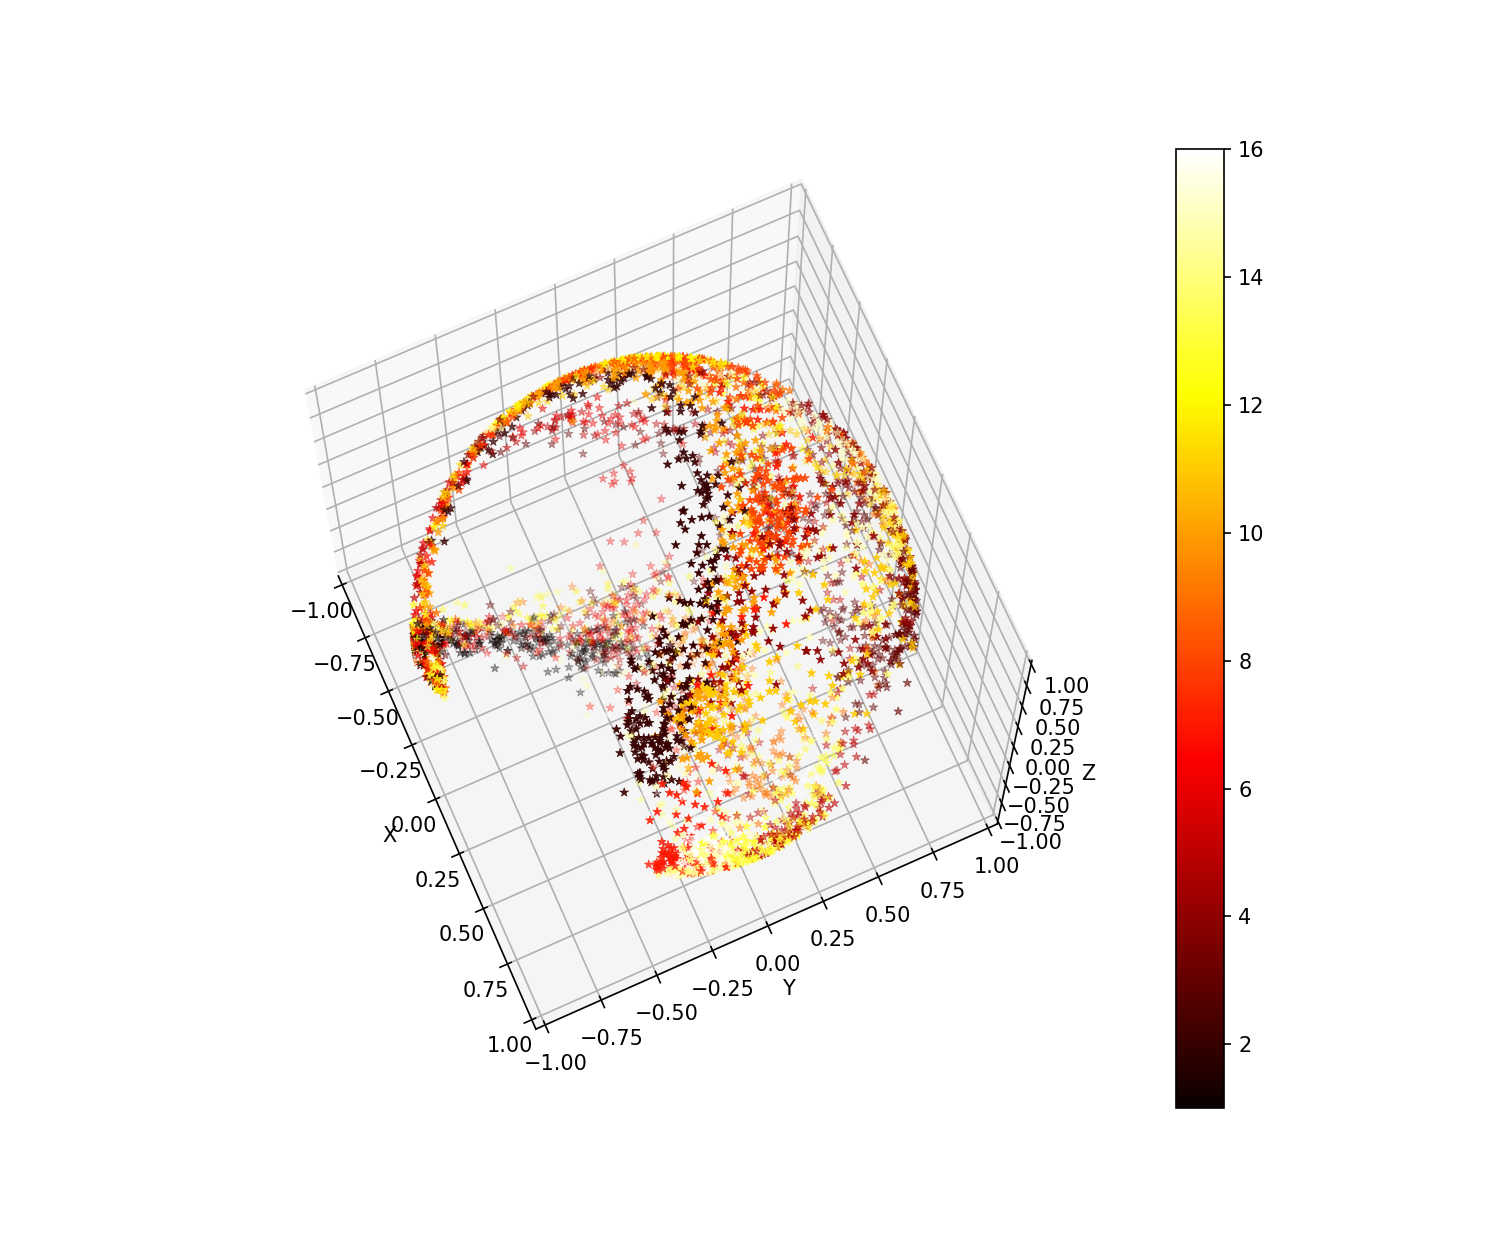

In [146]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
dic_compressed = np.load("kspace_unsupervised_resnet.npy")
# dic_compressed = B_tensor_cuda.detach().cpu().numpy()
# mrf_dict = scipy.io.loadmat('/mikRAID/jtamir/projects/MRF_direct_contrast_synthesis/data/DictionaryAndSequenceInfo/fp_dictionary.mat')
# print(MRF_dic.keys())
# fp_dict = mrf_dict['fp_dict']
# t1_list = mrf_dict['t1_list']
# t2_list = mrf_dict['t2_list']
# data = np.random.randint(0, 255, size=[40, 40, 40])
fig = plt.figure(figsize=(10,8.3))
# x, y, z = data[0], data[1], data[2]
ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
#  将数据点分成三部分画，在颜色上有区分度
# ax.scatter(x[:10], y[:10], z[:10], c='y')  # 绘制数据点
# ax.scatter(x[10:20], y[10:20], z[10:20], c='r')
# ax.scatter(x[30:40], y[30:40], z[30:40], c='g')
p = ax.scatter(dic_compressed[:,0], dic_compressed[:,1], dic_compressed[:,2],c = dic_case, marker = '*',linewidths=0.3,cmap = "hot")
ax.set_xlim([-1, 1])
ax.set_zlim([-1,1])
ax.set_ylim([-1, 1])
fig.colorbar(p)
ax.set_zlabel('Z')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')


# fig1 = plt.figure(figsize=(10,8.3))
# # x, y, z = data[0], data[1], data[2]
# ax1 = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
# #  将数据点分成三部分画，在颜色上有区分度
# # ax.scatter(x[:10], y[:10], z[:10], c='y')  # 绘制数据点
# # ax.scatter(x[10:20], y[10:20], z[10:20], c='r')
# # ax.scatter(x[30:40], y[30:40], z[30:40], c='g')
# p1 = ax1.scatter(dic_compressed[:,0], dic_compressed[:,1], dic_compressed[:,2], c=t_color,marker = '*',linewidths=0.3,cmap = "hot")
# ax1.set_xlim([-1, 1])
# ax1.set_zlim([-1,1])
# ax1.set_ylim([-1, 1])
# # fig1.colorbar(p1)
# ax1.set_zlabel('Z')  # 坐标轴
# ax1.set_ylabel('Y')
# ax1.set_xlabel('X')
plt.show()
